# Analyzing the commenters under a YouTuber's videos

In [1]:
import polars as pl
from plotnine import ggplot, geom_point, geom_col, geom_line, aes, scale_color_identity, labs, theme, element_text, scale_x_datetime, scale_x_discrete, theme_minimal, facet_wrap, guides, geom_smooth, coord_flip, geom_text, scale_x_continuous, geom_segment
from mizani.breaks import date_breaks
from mizani.formatters import date_format

#### The youtuber to be analyzed

In [2]:
video_file = "./corpus/tatiana_ventose_videos.csv"
comment_file = "./corpus/tatiana_ventose_comments.csv"
commenter_file = "./corpus/tatiana_ventose_commenters.csv"
ytb = "tatiana_ventose"
ytb_name = "Tatiana Ventôse"

In [3]:
videos = pl.read_csv(video_file).with_columns(
    pl.col('published_at').str.to_datetime(),
    pl.col('duration').str.replace_all("^PT([0-9]{1,2})S$", "00:00:$1").str.replace_all("^PT([0-9]{1,2})M([0-9]{1,2})S$", "00:$1:$2").str.replace_all("^PT([0-9]{1,2})H([0-9]{1,2})M([0-9]{1,2})S$", "$1:$2:$3").str.replace_all("^PT([0-9]{1,2})M$", "00:$1:00").str.to_time("%H:%M:%S"),
    pl.col("tags").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("gensim_topics").str.split(by="|"),
    pl.col("comment_count").fill_null(-1),
    pl.col("view_count").fill_null(-1),
    pl.col("like_count").fill_null(-1)
)

In [4]:
commenters = pl.read_csv(commenter_file).with_columns(
        pl.col('published_at').str.to_datetime(),
    pl.col("description").str.replace_all("^$", "Not_provided"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("keywords").fill_null("Not_provided").str.split(by="|"),
)

In [6]:
comments = pl.read_csv(comment_file).with_columns(
    pl.col('published_at').str.slice(0, length=4).alias("year"),
    pl.col('updated_at').str.to_datetime(), 
    pl.col('published_at').str.to_datetime(),
    pl.col("like_count").fill_null(0),
    pl.col("reply_count").fill_null(0),
    pl.col("author_channel_id").alias("channel_id")
).filter(
    pl.col("position") != 0
)

In [6]:
# we verify that we have the correct number of comments (we won't)
comments.select(["video_id", "comment_id"]) \
        .group_by("video_id").agg(pl.col("comment_id").alias("comments")) \
        .with_columns(pl.col("comments").list.len()) \
        .join(videos.select(["video_id", "comment_count"]), on='video_id', how='left') \
        .filter(pl.col('comments') != pl.col('comment_count'))

video_id,comments,comment_count
str,u32,i64
"""nnplfUlO7Qw""",248,387
"""NIH5ynMAL0Q""",526,839
"""f2FJ_erFRuk""",523,1225
"""GHF1kmfcVhM""",925,3928
"""uSYmKgf2vWA""",196,512
"""E5Sf_-8IuI0""",491,1806
"""XsBv8WAVffk""",2203,3334
"""HlxXzRE_lpM""",1767,4398
"""c4PLIkaWO9E""",1517,2757


In [8]:
# we analyze the update dates of the comments
updated_comments = comments.filter(pl.col('updated_at') != pl.col('published_at')) \
            .with_columns((pl.col('updated_at') - pl.col('published_at')).alias('soustraction')) \
            .select(['comment_id', 'channel_id', 'text', 'soustraction']) \
            .filter(pl.col('soustraction') > pl.duration(days=7)) \
            .sort(by='soustraction')
updated_comments

comment_id,channel_id,text,soustraction
str,str,str,duration[μs]
"""Ugx1WQwKJW5AvhFBlD94AaABAg""","""UCmO5W_wvfaOGGniPbtixPxA""","""C'est une protest song, comme …",7d 1h 44m 31s
"""Ugz3s1eKgxm0rcVyP_B4AaABAg""","""UCvRXvfeSLb3F94yOCVj8kdQ""","""N'importe quoi... ""Macron frap…",7d 5h 20m 50s
"""Ugy52UId-Tm2e4XNB3Z4AaABAg""","""UCaW4cmYJYxxYEKqqxUsBjqA""","""Ce que tu dis est très intéres…",7d 5h 33m 38s
"""UgwkZc5B4FThYWsovo54AaABAg""","""UCSDZWtComOdXb6uYzrrmTDQ""","""""La droite a gagné les électio…",7d 6h 37m 48s
"""UgyPZ0bv-F9YFXVq8BB4AaABAg.9Wh…","""UCi0Qj7AkEPxdyDSQ5d_GRZQ""","""@@jpb9254 Moi, je fais la même…",7d 8h 26m 49s
…,…,…,…
"""UgzoLtSd6umE2t_rwyp4AaABAg""","""UCKP0QWEbpJh_ekJtTxZVrhQ""","""Tu verras qu'à l'horizon 2030 …",2181d 16h 1m 43s
"""UgxVAouym3lAypPzHA14AaABAg.8Z_…","""UCA4_bTVSaCHbm5Bgqhl-wZA""","""@Dragon Boule : Internet.... l…",2187d 4h 45m 40s
"""UgxWMChJeVteHmzKZdZ4AaABAg.8Xz…","""UCRPKbvcAlwU0SbBTWW5Giqw""","""@Didy Petite Fumée Je prefere …",2187d 21h 51m 46s


## commenters and repliers

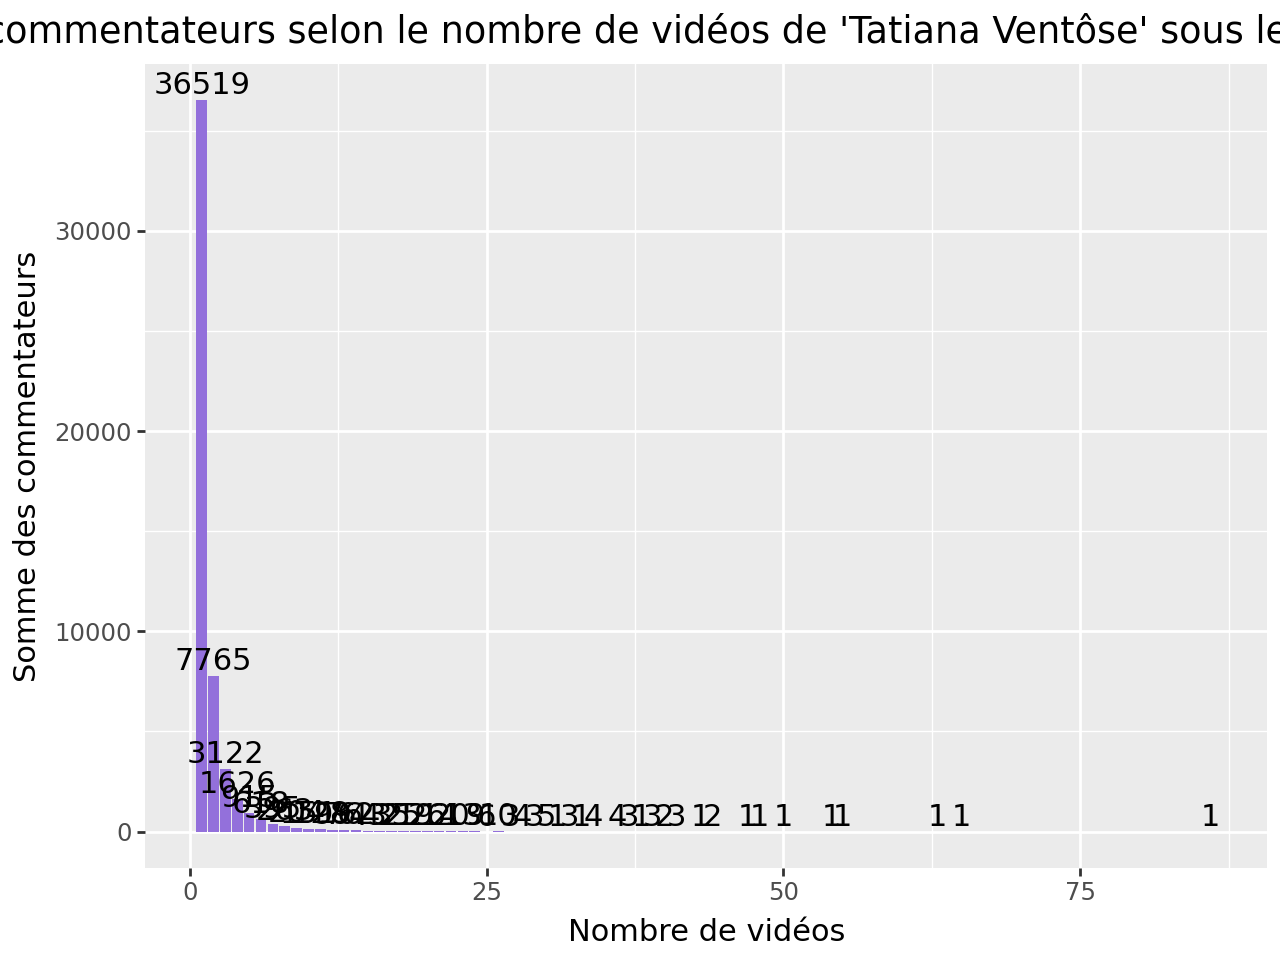

In [12]:
com = coms.filter(pl.col("channel_title") != ytb_name) \
        .select(['video_id', 'channel_id']) \
        .group_by("channel_id").agg(pl.col("video_id").alias("number of videos")) \
        .with_columns(pl.col('videos').list.unique().list.len().cast(pl.Int64)) \
        .group_by("videos").agg(pl.col("channel_id").alias("number of commenters")) \
        .with_columns(pl.col('channels').list.unique().list.len().cast(pl.Int64)) \
        .sort(by='number of videos')

p = ggplot(com, aes("videos", "channels")) \
        + geom_col(fill='mediumpurple') \
        + geom_text(aes(label='channels'), va='bottom', ha='center', format_string='{:.0f}') \
        + labs(title=ytb_name, x="Number of videos", y="Number of commenters")
p.show()

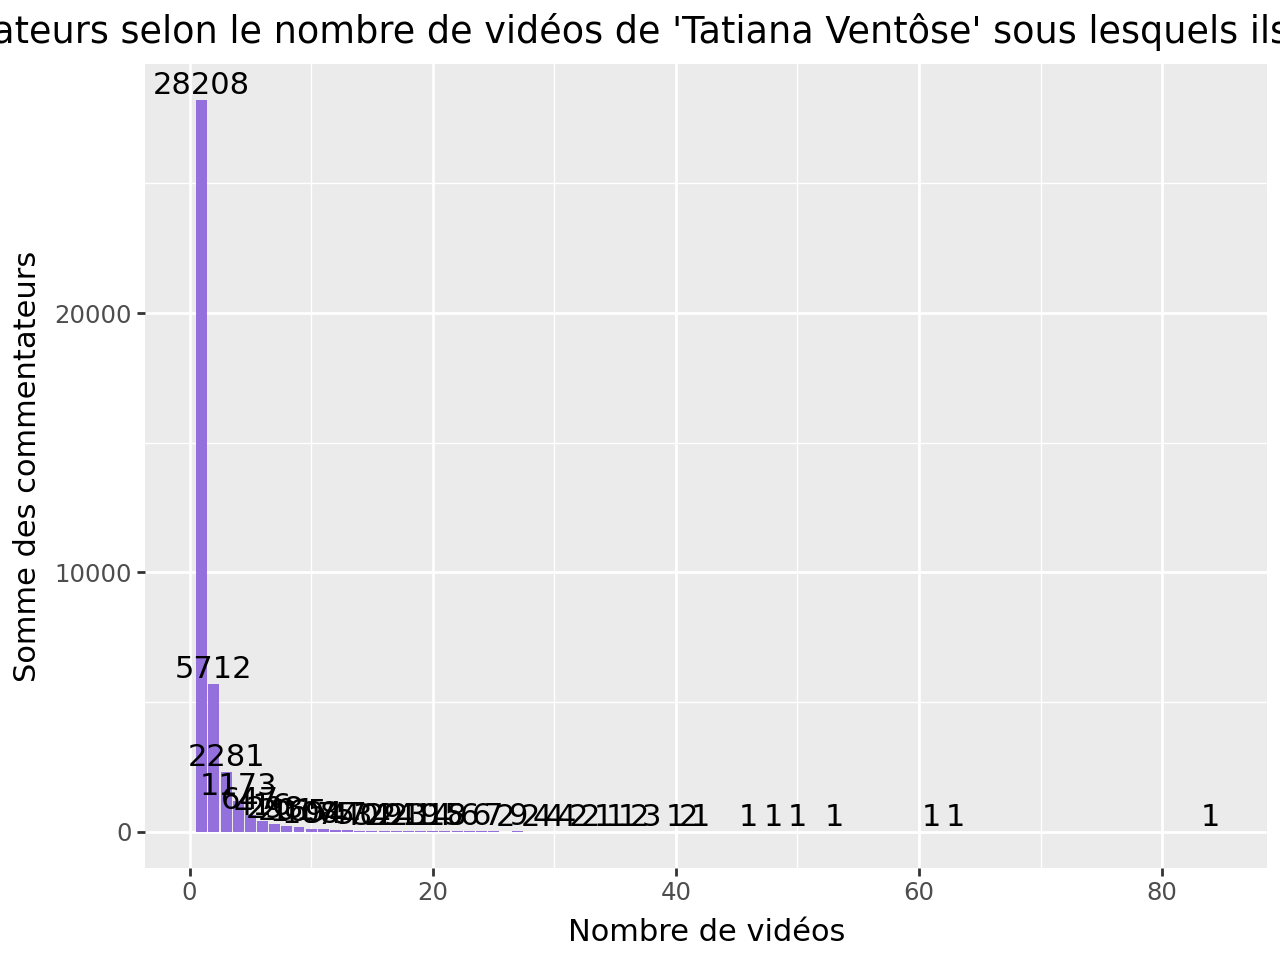

In [14]:
com = coms.filter(pl.col("channel_title") != ytb_name) \
        .filter(pl.col('position') > 1) \
        .select(['video_id', 'channel_id']) \
        .group_by("channel_id").agg(pl.col("video_id").alias("videos")) \
        .with_columns(pl.col('videos').list.unique().list.len().cast(pl.Int64)) \
        .group_by("videos").agg(pl.col("channel_id").alias("channels")) \
        .with_columns(pl.col('channels').list.unique().list.len().cast(pl.Int64)) \
        .sort(by='videos')

p = ggplot(com, aes("videos", "channels")) \
        + geom_col(fill='mediumpurple') \
        + geom_text(aes(label='channels'), va='bottom', ha='center', format_string='{:.0f}') \
        + labs(title=ytb_name, x="Number of videos", y="Number of commenters")
p.show()

## Well-known commenters

In [18]:
t = coms.filter(pl.col("channel_title") != ytb_name) \
    .filter(pl.col('view_count') >= 500000) \
    .select(['channel_id', 'channel_title', 'description', 'view_count', 'subscriber_count', 'video_id', 'comment_id', 'text', 'published_at']) \
    .sort(by='view_count', descending=True)
t

channel_id,channel_title,description,view_count,subscriber_count,video_id,comment_id,text,published_at
str,str,str,i64,i64,str,str,str,"datetime[μs, UTC]"
"""UCDkl5M0WVaddTWE4rr2cSeA""","""Lena Situations""","""désolée je suis nulle pour les descriptions """,565261686,2870000,"""Ac60SR3Ooks""","""UgwmVNS31L64KvpfA8B4AaABAg.8rPrQ7eMu6O8rQtzt8L2Ww""","""Mdrrrrr""",2019-02-16 22:22:11 UTC
"""UCDkl5M0WVaddTWE4rr2cSeA""","""Lena Situations""","""désolée je suis nulle pour les descriptions """,565261686,2870000,"""Ac60SR3Ooks""","""UgznQVC8UOsQ3XcJeLd4AaABAg""","""sooooo tu as écouté la chanson en boucle, tu l’as téléchargé et tu as appris les paroles par cœur ? …",2019-02-16 22:19:06 UTC
"""UC4peNo-31r7fhQZgu0_JRIA""","""Sheshounet""","""Je suis Sheshounet et le contenu que je propose est immature. J'ai commencé les vidéos en 2006 (sur …",226294664,1150000,"""C6l-xOyhyJs""","""UgwO7V3HLZeuWvaN8Gx4AaABAg""","""Les fonds d'investissements sont le cancer de l'économie.""",2021-01-28 09:52:16 UTC
"""UC4peNo-31r7fhQZgu0_JRIA""","""Sheshounet""","""Je suis Sheshounet et le contenu que je propose est immature. J'ai commencé les vidéos en 2006 (sur …",226294664,1150000,"""VruAtmev4LQ""","""UgxH-1dKkjPaoLkfS_t4AaABAg""","""Ca fait longtemps que c'est une cour de récréation en politique, même au collège on était plus consc…",2020-02-23 16:49:49 UTC
"""UCda1kM0KW5kzSW2bR1KfhFg""","""ludocaba""","""je suis une personne à mobilité réduite je suis handicapé musculaire avec une maladie qui s'appelle …",195805796,429000,"""4f9N3JNTq_U""","""UgzE_ibaI6E4o4ms1eN4AaABAg""","""c'est normal tous au gouvernement la soupe est bonne ça sert à rien d'aller voter""",2021-06-29 21:50:36 UTC
"""UCJYYeR3s7vCB6CsXZNQdYXg""","""Bilal Hassani""","""Bilal Hassani is a 23-year-old author, composer, and performer who shares his daily life with nearly…",188838617,1040000,"""Ac60SR3Ooks""","""UgwHDF0rFi8eod0Tw3h4AaABAg""","""respire meuf c’est une chanson""",2019-02-16 01:27:05 UTC
"""UCrCcpeVQlTCdoOId4yDUsZQ""","""Psyhodelik""","""Psyhodelik est un vidéaste passionné qui, à ses heures perdues, s'adonne à la création de contenus v…",187254893,248000,"""2l1vZx3yP1I""","""UgxF7Kr4hyK14c_yS914AaABAg""","""C'est ouf, et surtout alarmant de voir comment les journaliste devienne peu a peu le ""ministère de l…",2023-09-24 17:14:00 UTC
"""UCrCcpeVQlTCdoOId4yDUsZQ""","""Psyhodelik""","""Psyhodelik est un vidéaste passionné qui, à ses heures perdues, s'adonne à la création de contenus v…",187254893,248000,"""4f9N3JNTq_U""","""UgyeCSWZXcIBYQq9klZ4AaABAg""","""J'ai pas voté non plus et les présidentiels non plus je pense également""",2021-06-29 17:24:11 UTC
…,…,…,…,…,…,…,…,…


In [19]:
t = coms.filter(pl.col("channel_title") != ytb_name) \
    .filter(pl.col('view_count') >= 500000) \
    .select(['channel_id', 'channel_title', 'description', 'view_count', 'video_id', 'comment_id']) \
    .group_by(['channel_id', 'channel_title', 'description', 'view_count']).agg(pl.col("video_id").alias("videos"), pl.col("comment_id").alias("comments")) \
    .with_columns(pl.col('videos').list.len(), pl.col('comments').list.len()) \
    .sort(by='videos', descending=True)
t.head()

channel_id,channel_title,description,view_count,videos,comments
str,str,str,i64,u32,u32
"""UCb665bsykheTRHrgCi64LrQ""","""Edison McCullen""","""Not_provided""",887765,177,177
"""UCEOCK3vNR-WPGA5ZKGCvu-Q""","""Nice Jungle""","""Soyez les bienvenues dans la jungle de Nice, une ville sans foi ni loi où seul le plus fort peut s'i…",674322,123,123
"""UCw3w5FFPq3HyxeNw2KPJfLg""","""Aldreius""","""Qui lira ?""",742589,108,108
"""UCW7gCJM3lrn3hoADvZJSO2g""","""Frederic Bezies""","""La plupart des vidéos sont utilisées sur des articles de mon blog : https://blog.fredericbezies-ep.f…",2603111,106,106
"""UCyM11SNLhUUKTySFF9RM-pg""","""TOTO INTERNATIONAL""","""Artist, Autist, Youtuber Inconnu des réseaux sociaux Chaîne internationale de connexion et de valo…",1086800,76,76


In [20]:
t = coms.filter(pl.col("channel_title") != ytb_name) \
    .filter(pl.col('subscriber_count') >= 100000) \
    .select(['channel_id', 'channel_title', 'description', 'view_count', 'subscriber_count', 'video_id', 'comment_id', 'text', 'published_at']) \
    .sort(by='subscriber_count', descending=True)
t.head()

channel_id,channel_title,description,view_count,subscriber_count,video_id,comment_id,text,published_at
str,str,str,i64,i64,str,str,str,"datetime[μs, UTC]"
"""UCDkl5M0WVaddTWE4rr2cSeA""","""Lena Situations""","""désolée je suis nulle pour les descriptions """,565261686,2870000,"""Ac60SR3Ooks""","""UgwmVNS31L64KvpfA8B4AaABAg.8rPrQ7eMu6O8rQtzt8L2Ww""","""Mdrrrrr""",2019-02-16 22:22:11 UTC
"""UCDkl5M0WVaddTWE4rr2cSeA""","""Lena Situations""","""désolée je suis nulle pour les descriptions """,565261686,2870000,"""Ac60SR3Ooks""","""UgznQVC8UOsQ3XcJeLd4AaABAg""","""sooooo tu as écouté la chanson en boucle, tu l’as téléchargé et tu as appris les paroles par cœur ? …",2019-02-16 22:19:06 UTC
"""UC4peNo-31r7fhQZgu0_JRIA""","""Sheshounet""","""Je suis Sheshounet et le contenu que je propose est immature. J'ai commencé les vidéos en 2006 (sur …",226294664,1150000,"""C6l-xOyhyJs""","""UgwO7V3HLZeuWvaN8Gx4AaABAg""","""Les fonds d'investissements sont le cancer de l'économie.""",2021-01-28 09:52:16 UTC
"""UC4peNo-31r7fhQZgu0_JRIA""","""Sheshounet""","""Je suis Sheshounet et le contenu que je propose est immature. J'ai commencé les vidéos en 2006 (sur …",226294664,1150000,"""VruAtmev4LQ""","""UgxH-1dKkjPaoLkfS_t4AaABAg""","""Ca fait longtemps que c'est une cour de récréation en politique, même au collège on était plus consc…",2020-02-23 16:49:49 UTC
"""UCJYYeR3s7vCB6CsXZNQdYXg""","""Bilal Hassani""","""Bilal Hassani is a 23-year-old author, composer, and performer who shares his daily life with nearly…",188838617,1040000,"""Ac60SR3Ooks""","""UgwHDF0rFi8eod0Tw3h4AaABAg""","""respire meuf c’est une chanson""",2019-02-16 01:27:05 UTC


In [21]:
t = coms.filter(pl.col("channel_title") != ytb_name) \
    .filter(pl.col('subscriber_count') >= 100000) \
    .select(['channel_id', 'channel_title', 'description', 'view_count', 'video_id', 'comment_id']) \
    .group_by(['channel_id', 'channel_title', 'description', 'view_count']).agg(pl.col("video_id").alias("videos"), pl.col("comment_id").alias("comments")) \
    .with_columns(pl.col('videos').list.len(), pl.col('comments').list.len()) \
    .sort(by='videos', descending=True)
t.head()

channel_id,channel_title,description,view_count,videos,comments
str,str,str,i64,u32,u32
"""UC9NB2nXjNtRabu3YLPB16Hg""","""J'suis pas content TV""","""J'suis pas content TV est une chaine humoristique, satirique et informative traitant essentiellemen…",131155303,28,28
"""UCrCcpeVQlTCdoOId4yDUsZQ""","""Psyhodelik""","""Psyhodelik est un vidéaste passionné qui, à ses heures perdues, s'adonne à la création de contenus v…",187254893,18,18
"""UC5X4e8ScZI2AFd_vkjSoyoQ""","""AstronoGeek""","""AstronoGeek, c'est une chaîne dédiée à la vulgarisation de l'astronomie. Bordel de merde.""",168969381,11,11
"""UCynFUJ4zUVuh3GX7bABTjGQ""","""Trouble Fait""","""Je vous propose une plongée dans les Troubles Faits des médias, de l’économie, de la politique et de…",24366047,7,7
"""UCyeoIdJHgQhOrct9mVJ2fTQ""","""Le Petit Astronome""","""Des histoires sur la vie, l'Univers, et tout le reste. """,26281335,6,6


## The commenters over time

In [27]:
com = comments.select(['published_at', 'channel_id']) # 1. on sélectionne date de publication et channel id
com = com.with_columns(pl.col('published_at').str.replace_all("T", " ").str.slice(0, length=10).str.to_date("%F")) # 2. on enlève l'heure
com = com.group_by('channel_id').agg(pl.col("published_at").alias("years")) # 3. pour chaque utilisateur, on fait une liste de toutes les dates de publications de leurs commentaires
com = com.with_columns(min_year=pl.date(pl.col('years').list.min().dt.year(), 1, 1), max_year=pl.date(pl.col('years').list.max().dt.year(), 12, 31)) # 4. on garde la date la plus petite et la plus grande qu'on transforme en 01/01 pour la plus petite et 31/12 pour la plus grande
com = com.drop('years') # 5. on supprime l'ancienne colonne qui ne nous sert plus
com = com.group_by(['min_year', 'max_year']).agg(pl.col("channel_id").alias("channel_count")) # 6. on faite les liste des channel_id selon leur première et leur dernière année d'apparition dans l'espace commentaire
com = com.with_columns(pl.col('channel_count').list.len().cast(pl.Int32)) # 7. on calcule le nombre de personnes dans chaque liste
com = com.sort(by=['min_year', 'channel_count']) # 8. sorting par première année d'apparition puis par nombre de commentateurs par ligne
com

min_year,max_year,channel_count
date,date,i32
2016-01-01,2023-12-31,4
2016-01-01,2021-12-31,5
2016-01-01,2022-12-31,7
2016-01-01,2024-12-31,9
2016-01-01,2020-12-31,10
2016-01-01,2018-12-31,11
2016-01-01,2019-12-31,11
2016-01-01,2017-12-31,12
…,…,…


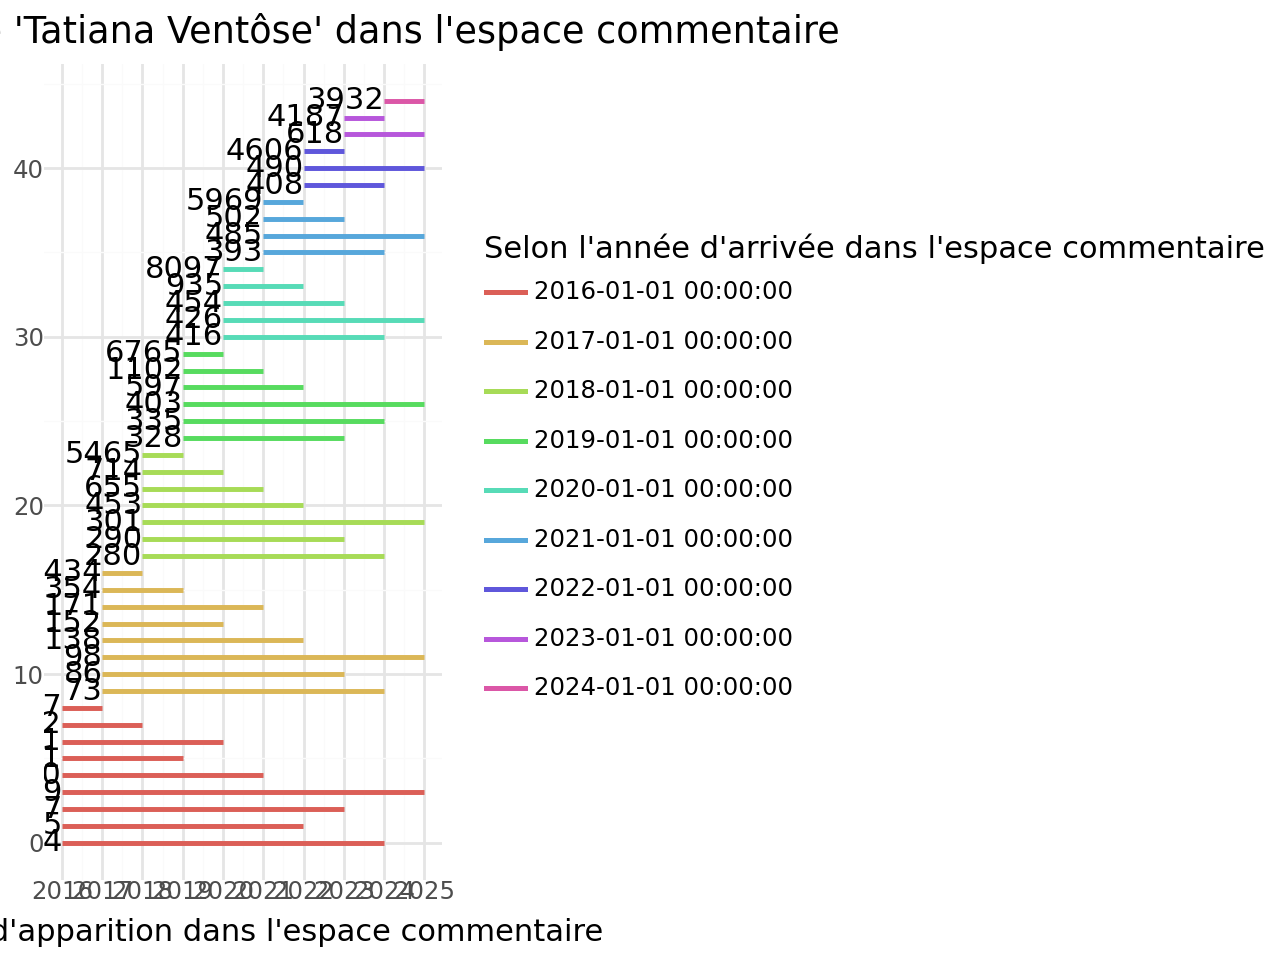

In [28]:
# theme_minimal enlève le fond gris
df = com.with_columns(pl.Series(name='index', values=range(com.shape[0])))
p = ggplot(df, aes(x='min_year', xend='max_year', y='index', yend='index', color="factor(min_year)")) \
        + geom_segment(size=1) \
        + theme_minimal() \
        + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y")) \
        + geom_text(aes(label='channel_count'), va='center', ha='right', format_string='{:.0f}', color='black') \
        + labs(title=f"La communauté de '{ytb_name}' dans l'espace commentaire", x="Année d'apparition dans l'espace commentaire", y='', color="Selon l'année d'arrivée dans l'espace commentaire")
p.show()